this notebook is to demonstrate the how I deal with the  **gap data** in VIIRS\
it is quite important because VIIRS special design of dealing with [bow-tie effect](https://www.researchgate.net/figure/The-MODIS-Bowtie-effect-illustrated-on-one-side-of-the-swath-for-three-successive-scans_fig1_325708879),\
instead of having repeated data like MODIS, VIIRS just cropped them which caused the gap, \
see below

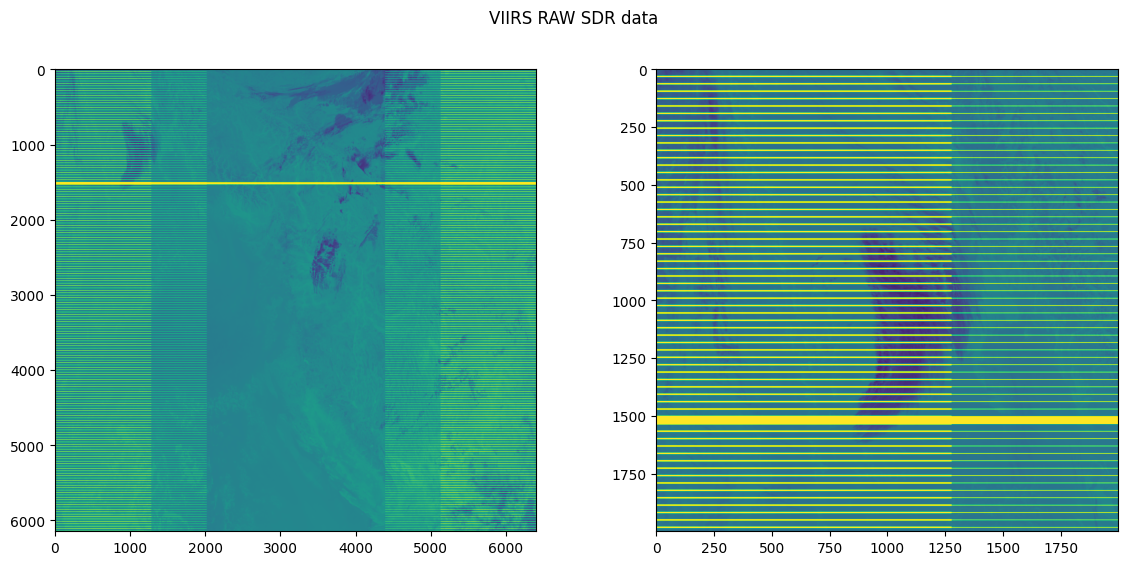

In [13]:
import os
os.chdir("/workspaces/fire-detection/")

import h5py
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

test_file = "data/GIMGO-SVI04-SVI05_j01_d20220722_t1003522_e1009322_b24219_c20220818221532599234_oebc_ops.h5"


xr = h5py.File(test_file,'r')
bt_4s = xr['All_Data']['VIIRS-I4-SDR_All']['BrightnessTemperature'][:]
bt_4s_sf = xr['All_Data']['VIIRS-I4-SDR_All']['BrightnessTemperatureFactors'][:2]
I4_bt_arr = np.array(bt_4s*bt_4s_sf[0]+bt_4s_sf[1])

fig,axes = plt.subplots(figsize=(14,6),ncols=2)
ax0,ax1 = axes.flat
ax0.imshow(I4_bt_arr)
ax1.imshow(I4_bt_arr[:2000,:2000])
plt.suptitle('VIIRS RAW SDR data')
plt.show()

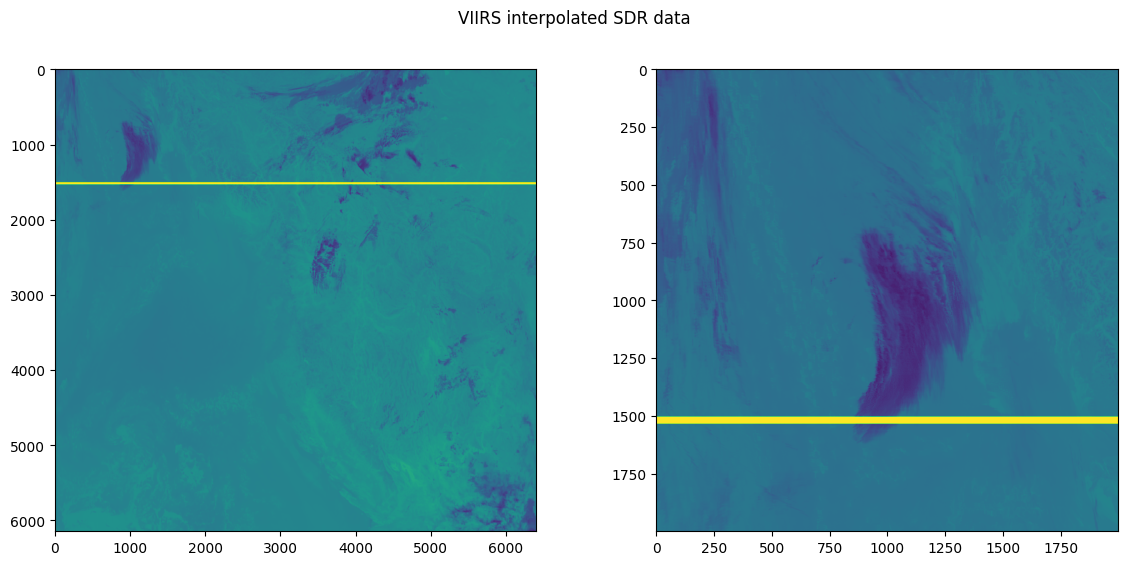

In [14]:

def get_delete_list_in_agg_zone(agg_zone:int)->np.array:
    nx = 1536*4
    ny = 6400 # notice this number might change based on 85s/5min granule 
    if agg_zone == 1 or agg_zone == 6:
        crop_list = [0,1,2,3,28,29,30,31]
    elif agg_zone == 2 or agg_zone == 5:
        crop_list = [0,1,30,31]
    elif agg_zone == 3 or agg_zone == 4:
        return []
    agg_crop_list = []
    for i in crop_list:
        agg_crop_list.append(32*np.arange(int(nx/32))+i)
    agg_crop_list = np.array(agg_crop_list).reshape(-1)
    return agg_crop_list

def get_viirs_agg_zone(agg_zone:int):
    # definition of different aggregation zone
    viirs_agg_list = [1280,2016,3200,4384,5120,6400]

    # use match/case from python3.10 update
    # pretty clear, i like it :)
    match agg_zone:
        case 1:
            return (0,viirs_agg_list[0])
        case 2:
            return (viirs_agg_list[0],viirs_agg_list[1])
        case 3:
            return (viirs_agg_list[1],viirs_agg_list[2])
        case 4:
            return (viirs_agg_list[2],viirs_agg_list[3])
        case 5:
            return (viirs_agg_list[3],viirs_agg_list[4])
        case 6:
            return (viirs_agg_list[4],viirs_agg_list[5])

def bowtie_crop_interpolate(viirs_arr:np.array,agg_zone:int)->np.array:
    agg_zone_i,agg_zone_j = get_viirs_agg_zone(agg_zone)
    agg_crop_list = get_delete_list_in_agg_zone(agg_zone)

    agg_zone_arr = viirs_arr[:,agg_zone_i:agg_zone_j]
    agg_zone_nx,agg_zone_ny = agg_zone_arr.shape
    agg_zone_del = np.delete(agg_zone_arr, agg_crop_list, 0)
    agg_zone_interp = resize(agg_zone_del,(agg_zone_nx,agg_zone_ny),order=2)
    viirs_arr[:,agg_zone_i:agg_zone_j] = agg_zone_interp
    return viirs_arr


for agg_zone in [1,2,5,6]:
    I4_bt_arr = bowtie_crop_interpolate(I4_bt_arr,agg_zone)

fig,axes = plt.subplots(figsize=(14,6),ncols=2)
ax0,ax1 = axes.flat
ax0.imshow(I4_bt_arr)
ax1.imshow(I4_bt_arr[:2000,:2000])
plt.suptitle('VIIRS interpolated SDR data')
plt.show()
